In [1]:
import tensorflow as tf

In [586]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import signal

In [3]:
import pandas as pd

In [5]:
#!pip install pandas_datareader

In [6]:
from pandas_datareader import data

In [432]:
basket = ['EAT', 'TWTR', 'TTNP', 'SBUX', 'BAC', 'SHLDQ', 'STM', 'ACB', 'GREK']

In [8]:
df = data.DataReader(basket, 'robinhood')

In [8]:
# TODO: Should duplicate items in the basket in different orders to expand the training set

In [433]:
df.head()

,symbol,close_price,high_price,low_price,open_price,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
0,EAT,-0.427304,-0.485470,-0.516986,-0.471408,-0.270106,-0.435157,-0.558293,-0.886512,0.483269,-0.427304,-0.105177,1.0,4.0,49.0
1,EAT,-0.547876,-0.442165,-0.510706,-0.438307,-0.408546,-0.487346,-0.502346,-0.253333,-0.397686,-0.547876,-0.609083,2.0,4.0,49.0
2,EAT,-0.588804,-0.569539,-0.531462,-0.601472,-0.531103,-0.569780,-0.552373,-0.746543,-0.215988,-0.588804,-0.320145,3.0,4.0,49.0
3,EAT,-0.539103,-0.533364,-0.550011,-0.594961,-0.582167,-0.565303,-0.591437,-0.692217,-0.765559,-0.539103,0.008647,4.0,4.0,49.0
4,EAT,-0.444589,-0.497281,-0.471923,-0.537371,-0.515546,-0.491691,-0.555347,-0.414698,-0.318380,-0.444589,0.171226,0.0,4.0,50.0


In [434]:
#df = orig.copy()

In [435]:
orig = df.copy()

In [436]:
df=df.reset_index()

In [437]:
df.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume
0,EAT,2017-12-01,34.704400,35.821700,False,34.603300,35.465300,reg,1704952
1,EAT,2017-12-04,37.324300,37.555500,False,34.887400,34.887400,reg,2617215
2,EAT,2017-12-05,37.507300,37.647000,False,35.980600,37.256900,reg,2013373
3,EAT,2017-12-06,36.303300,38.114100,False,36.043200,37.603600,reg,1713866
4,EAT,2017-12-07,35.894600,36.740200,False,35.836300,35.894600,reg,1448719


In [438]:
X_scalers = {}
y_scalers = {}
for stock in basket:
    for col in ('close_price', 'high_price', 'low_price', 'open_price', 'volume'):
        df[col] = df[col].astype(float)
        df.loc[df['symbol'] == stock, col] = signal.detrend(df[df['symbol'] == stock][col])
    df.loc[df['symbol'] == stock, 'mean_close_price_2'] = df.loc[df['symbol'] == stock, 'close_price'].rolling(window=2).mean()
    df.loc[df['symbol'] == stock, 'mean_close_price_3'] = df.loc[df['symbol'] == stock, 'close_price'].rolling(window=3).mean()
    df.loc[df['symbol'] == stock, 'std_close_price_2'] = df.loc[df['symbol'] == stock, 'close_price'].rolling(window=2).std()
    df.loc[df['symbol'] == stock, 'std_close_price_3'] = df.loc[df['symbol'] == stock, 'close_price'].rolling(window=3).std()

In [439]:
X_scalers = {stock:{} for stock in basket}
y_scalers = {}

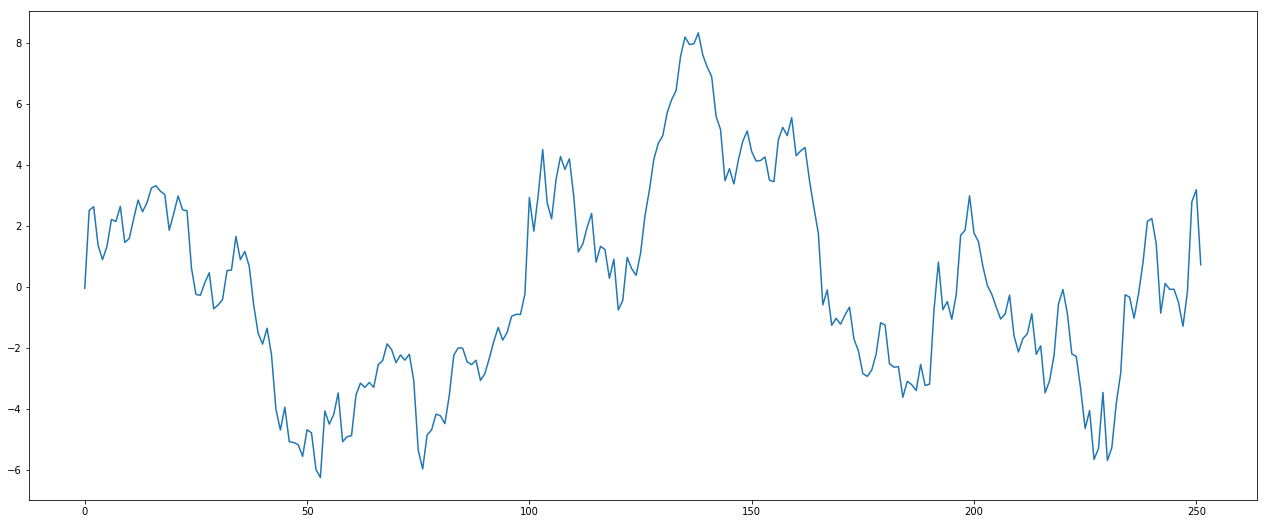

In [440]:
plt.plot(df[df['symbol'] == 'EAT']['close_price'])

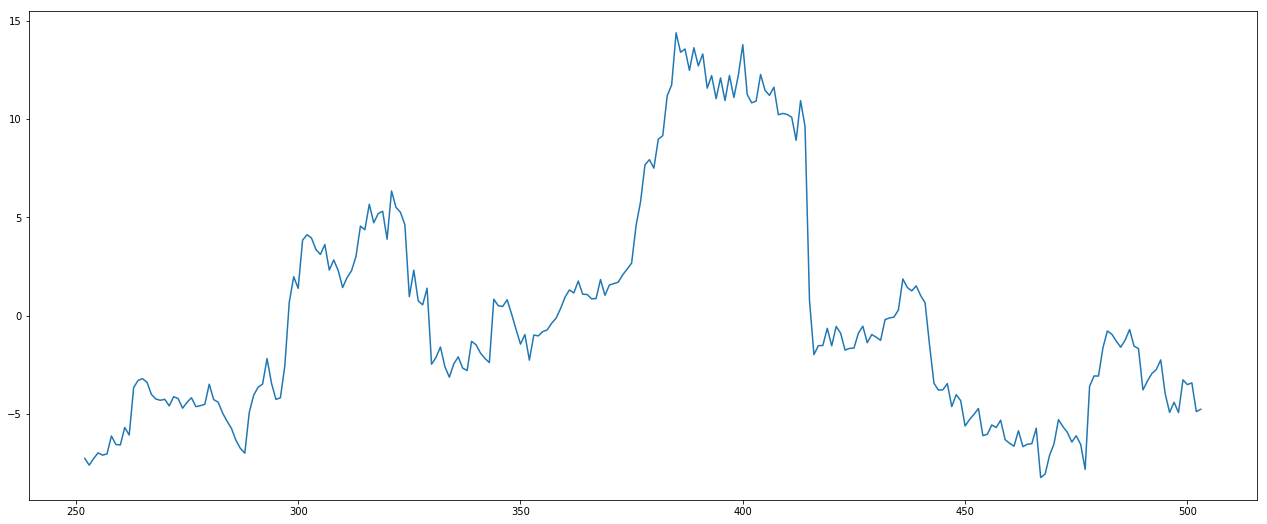

In [441]:
plt.plot(df[df['symbol'] == 'TWTR']['close_price'])

In [442]:
df['tomo_gain'] = df['close_price'].shift(-1) - df['close_price']
df['yday_gain'] = df['tomo_gain'].shift(1)

# This is not ok - note the last one

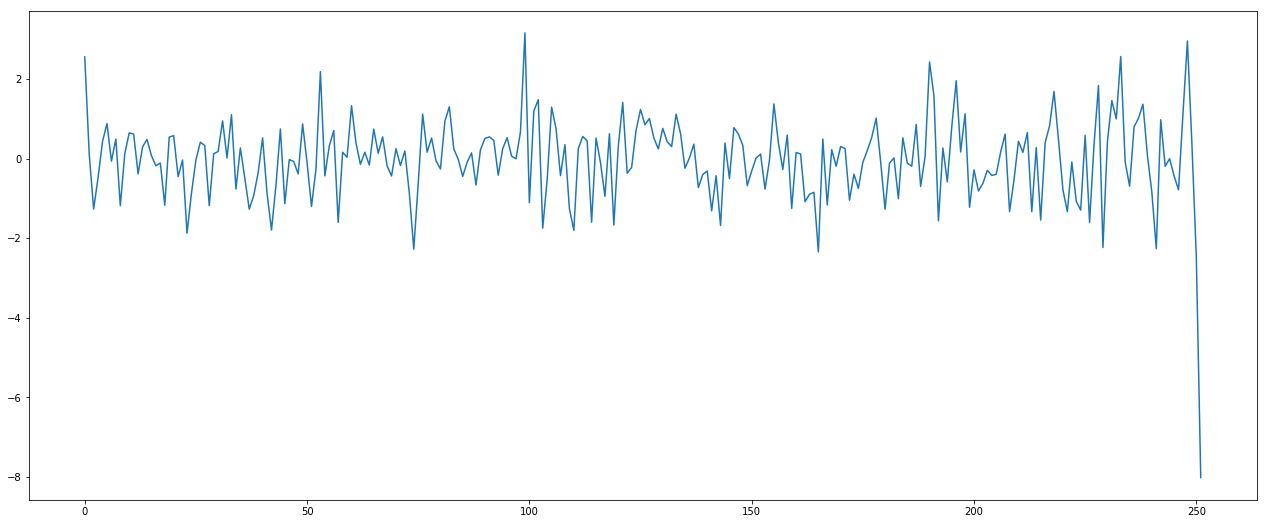

In [443]:
plt.plot(df[df['symbol'] == 'EAT']['tomo_gain'])

# This is better

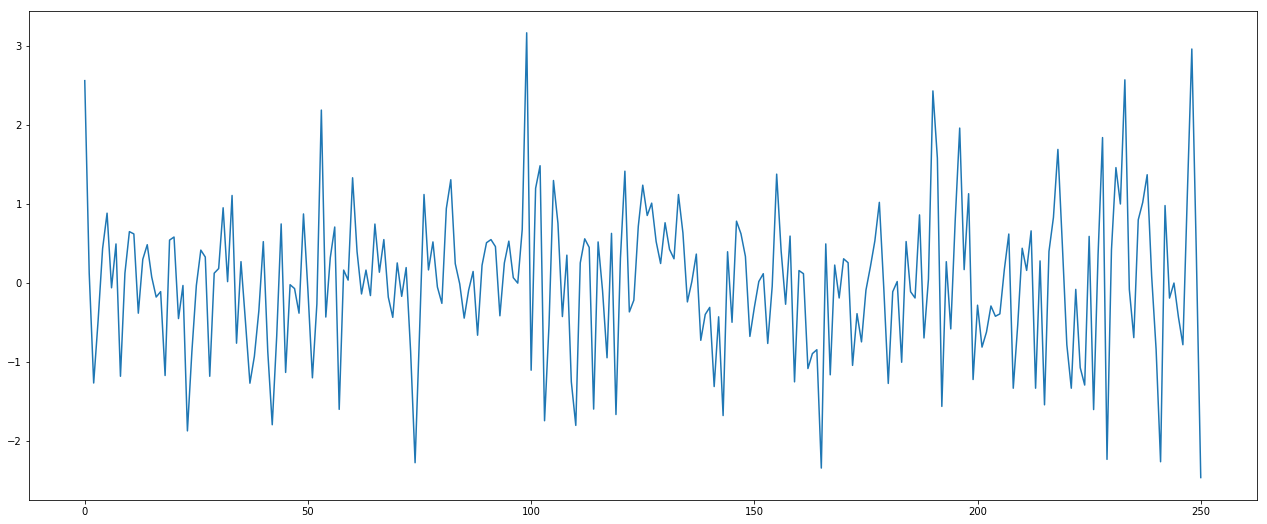

In [444]:
plt.plot(df[df['symbol'] == 'EAT'][:-1]['tomo_gain'])

In [445]:
as_date = df['begins_at'].dt
df['dayofweek'] = as_date.dayofweek
df['quarter'] = as_date.quarter
df['weekofyear'] = as_date.weekofyear

In [446]:
df = df.drop(['begins_at', 'interpolated', 'session'], axis=1)
df = df.dropna(axis=0) # Due to window, first two rows now contain nans
df = df.reset_index(drop=True)

In [447]:
df.head()

,symbol,close_price,high_price,low_price,open_price,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
0,EAT,2.639821,2.225293,1.534684,2.356876,378990.812735,2.579400,1.706679,0.085448,1.512804,-1.266158,0.120842,1,4,49
1,EAT,1.373663,2.629072,1.537174,2.641929,81829.491296,2.006742,2.177487,0.895309,0.698750,-0.470858,-1.266158,2,4,49
2,EAT,0.902804,1.191852,1.270165,0.871281,-180971.830142,1.138234,1.638763,0.332947,0.898340,0.434142,-0.470858,3,4,49
3,EAT,1.336946,1.518732,1.025156,0.877833,-289100.151581,1.119875,1.204471,0.306985,0.261895,0.881642,0.434142,4,4,49
4,EAT,2.218588,1.844612,1.743446,1.419385,-142623.473019,1.777767,1.486113,0.623415,0.670455,-0.062158,0.881642,0,4,50


In [448]:
for stock in basket:
    df = df.drop(df.index[len(df[df['symbol'] == stock]) - 1], axis=0)
    outliers = abs(df[df['symbol'] == stock]['tomo_gain']) < df[df['symbol'] == stock]['tomo_gain'].std() * 3
    df[df['symbol'] == stock] = df[df['symbol'] == stock].loc[:, :][outliers]
    df = df.drop(df[df['symbol'] == stock].iloc[-1].name) # get rid of last because next is a different stock
    #pre_y = df[df['symbol'] == stock]['close_price'].values
    pre_y = df[df['symbol'] == stock]['tomo_gain'].values
    y_scalers[stock] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
    y_scalers[stock] = MinMaxScaler(feature_range=(-1, 1))
    for col in ('close_price', 'high_price', 'low_price', 'open_price', 'volume', 'mean_close_price_2', \
               'mean_close_price_3', 'std_close_price_2', 'std_close_price_3', 'yday_gain'):
        pre_x = df[df['symbol'] == stock][col]
        X_scalers[stock][col] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
        df.loc[df['symbol'] == stock, col] = X_scalers[stock][col].fit_transform(pre_x.values.reshape(-1,1))
    df.loc[df['symbol'] == stock, 'tomo_gain'] = y_scalers[stock].fit_transform(pre_y.reshape(-1, 1)).reshape(-1)

# Note same shape but now different scale

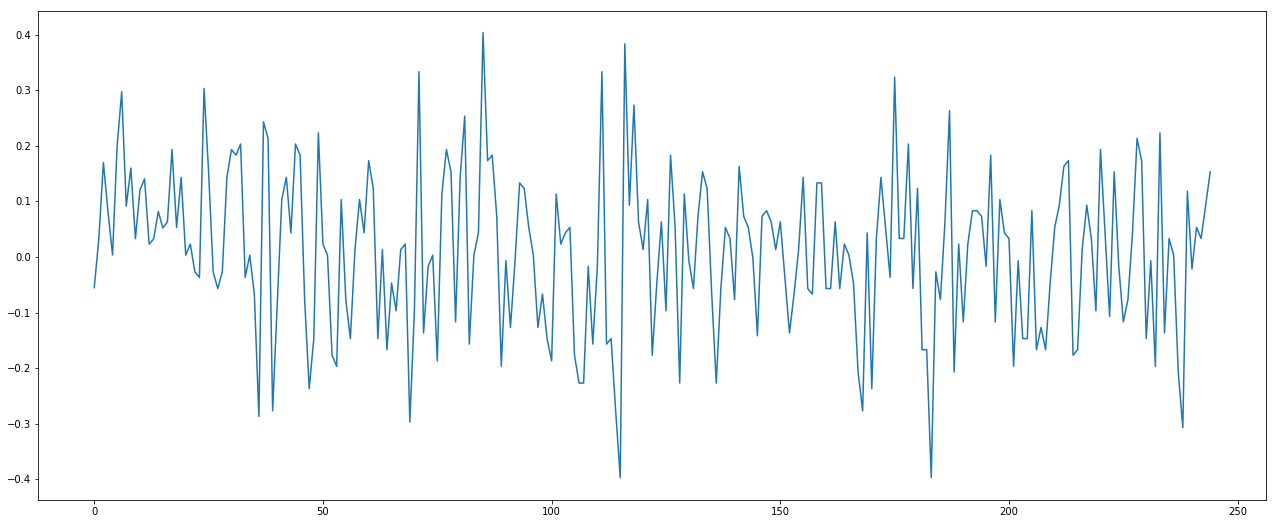

In [449]:
plt.plot(pre_y)

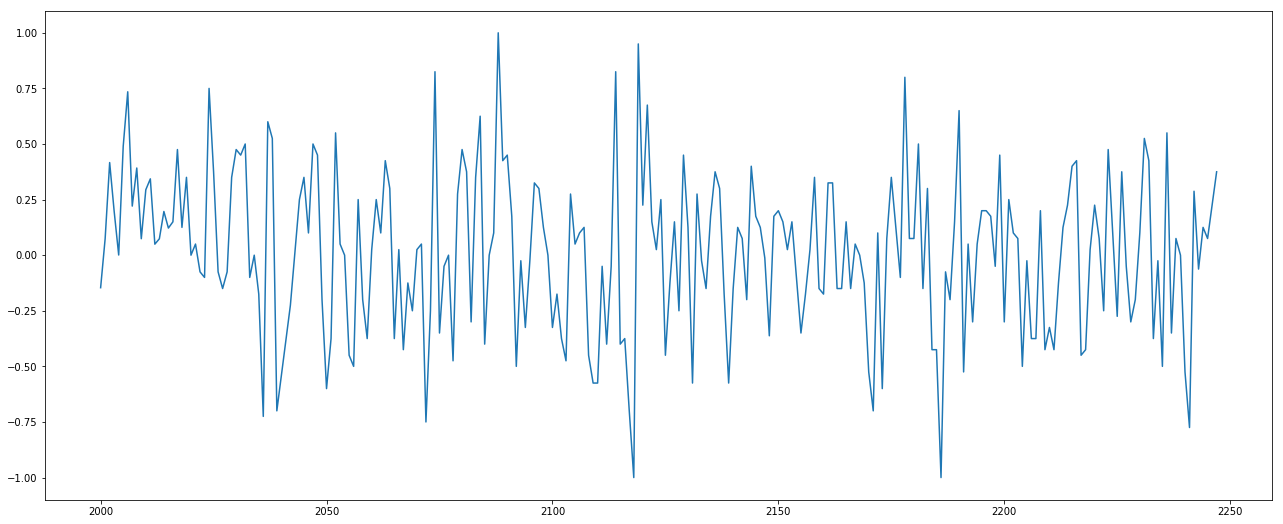

In [452]:
plt.plot( df.loc[df['symbol'] == basket[-1], 'tomo_gain'])

In [453]:
df = df.dropna(axis=0)

In [454]:
df.head()

,symbol,close_price,high_price,low_price,open_price,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
0,EAT,0.218040,0.084493,0.125207,0.139231,-0.337668,0.217812,0.071661,-0.924900,0.423800,-0.561711,-0.105177,1.0,4.0,49.0
1,EAT,0.044539,0.134372,0.125520,0.174146,-0.477900,0.137609,0.140048,-0.200173,-0.361580,-0.237760,-0.609083,2.0,4.0,49.0
2,EAT,-0.019983,-0.043167,0.091897,-0.042733,-0.601918,0.015969,0.061796,-0.703419,-0.169020,0.130876,-0.320145,3.0,4.0,49.0
3,EAT,0.039507,-0.002788,0.061043,-0.041930,-0.652944,0.013398,-0.001286,-0.726652,-0.783046,0.313157,0.008647,4.0,4.0,49.0
4,EAT,0.160319,0.037468,0.151495,0.024402,-0.583821,0.105539,0.039623,-0.443485,-0.388878,-0.071283,0.171226,0.0,4.0,50.0


In [455]:
df[df['symbol'] == 'EAT'].describe()

,close_price,high_price,low_price,open_price,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek,quarter,weekofyear
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,-0.147055,-0.194136,-0.069275,-0.151531,-0.519894,-0.146448,-0.179334,-0.563163,-0.421679,-0.055176,-0.151328,2.032520,2.487805,26.304878
std,0.449982,0.402521,0.413437,0.407460,0.275949,0.455324,0.468316,0.371532,0.389814,0.354368,0.330235,1.399329,1.109262,14.799908
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,1.000000
25%,-0.482383,-0.509883,-0.386857,-0.456151,-0.709078,-0.492427,-0.544012,-0.841627,-0.706911,-0.259287,-0.339346,1.000000,2.000000,14.000000
50%,-0.206005,-0.243099,-0.105749,-0.199907,-0.576392,-0.192547,-0.215638,-0.670588,-0.486304,-0.029267,-0.134187,2.000000,2.000000,26.000000
75%,0.187161,0.096688,0.210901,0.144555,-0.387547,0.191171,0.145253,-0.363959,-0.225793,0.166853,0.040736,3.000000,3.000000,39.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,52.000000


In [456]:
df.shape

(2204, 15)

In [457]:
num_df_cols = df.shape[1] - 1 + len(basket) - 1

In [512]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_df_cols, input_shape=(1, num_df_cols)))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1)) # dont squash output gradient

In [513]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [462]:
X = df.drop(['tomo_gain', 'symbol'], axis=1)
y = df['tomo_gain']

In [463]:
dummies = pd.get_dummies(df['symbol'], columns=['symbol'])

In [464]:
X = np.append(X, dummies.values, axis=1)

In [465]:
X.shape

(2204, 22)

In [468]:
# Reshape to num_samples, timesteps, num_features
X = np.reshape(X, (-1, 1, num_df_cols))

In [469]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (22, 9)

## Sanity check

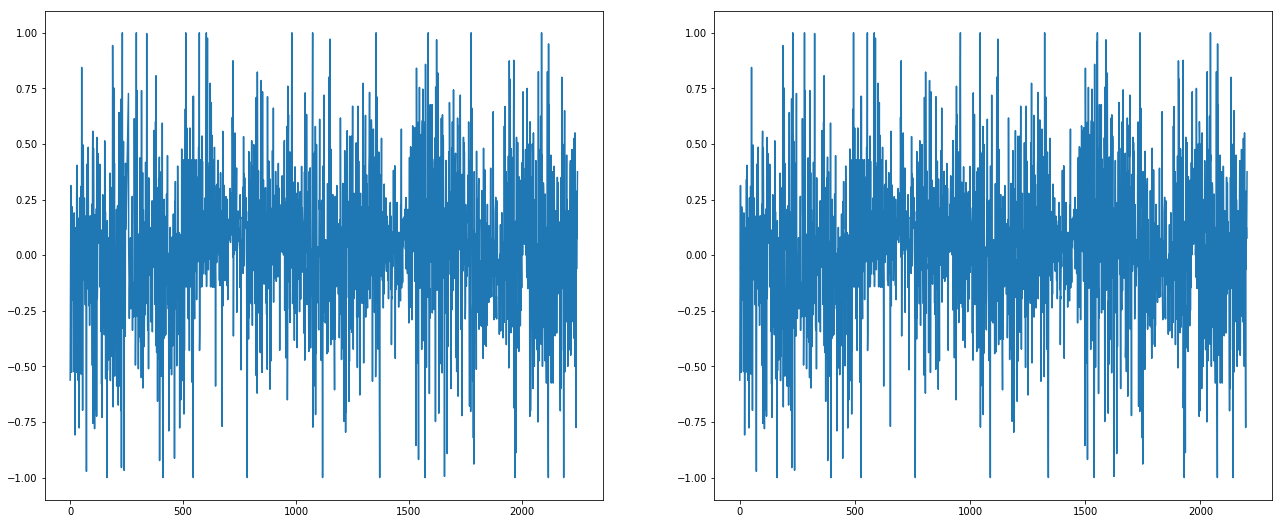

In [470]:
plt.subplot(1,2,1)
plt.plot(y)
plt.subplot(1,2,2)
plt.plot(df['tomo_gain'].values)

# Fit the base model

In [539]:
model.fit(X, y.values.reshape(-1,1), batch_size=64, epochs=1000, verbose=0)
model.fit(X, y.values.reshape(-1,1), batch_size=32, epochs=6)

Epoch 1/6
2204/2204 [==============================] - 0s 218us/step - loss: 0.0219 - mean_squared_error: 0.0219
Epoch 2/6
2204/2204 [==============================] - 0s 225us/step - loss: 0.0249 - mean_squared_error: 0.0249
Epoch 3/6
2204/2204 [==============================] - 1s 230us/step - loss: 0.0253 - mean_squared_error: 0.0253
Epoch 4/6
2204/2204 [==============================] - 1s 231us/step - loss: 0.0246 - mean_squared_error: 0.0246
Epoch 5/6
2204/2204 [==============================] - 0s 226us/step - loss: 0.0230 - mean_squared_error: 0.0230
Epoch 6/6
2204/2204 [==============================] - 0s 224us/step - loss: 0.0206 - mean_squared_error: 0.0206


# Sanity checks

In [540]:
model.reset_states()

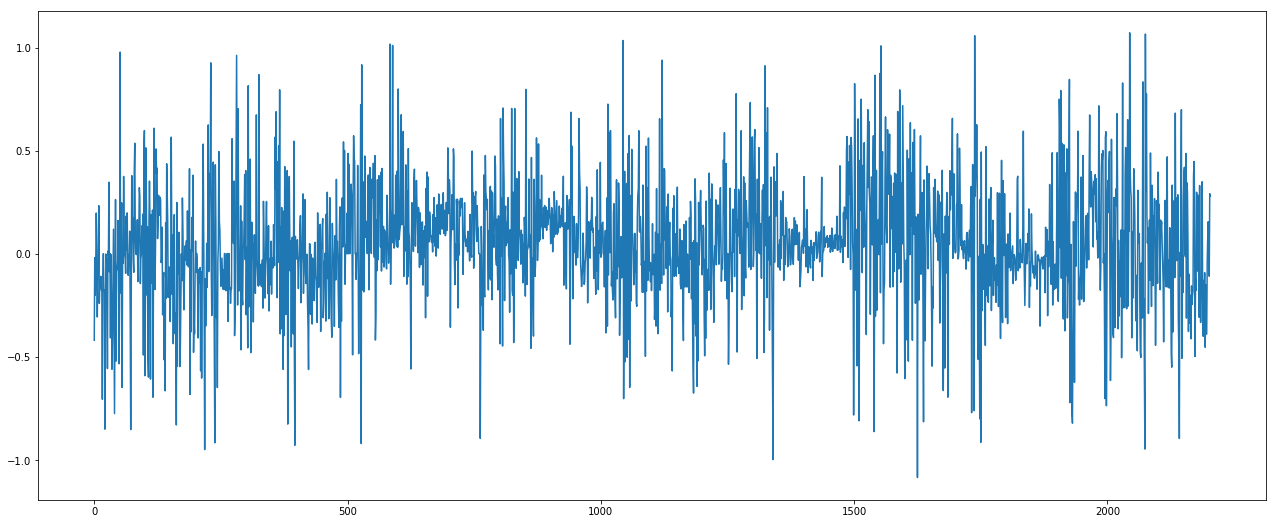

In [543]:
plt.plot(model.predict(X))

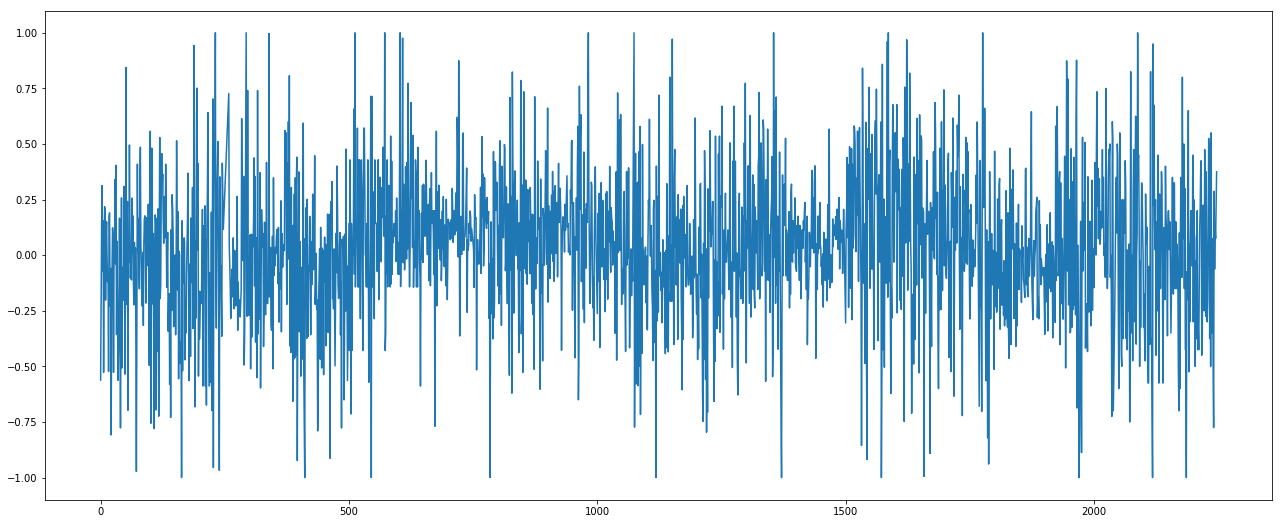

In [544]:
plt.plot(y)

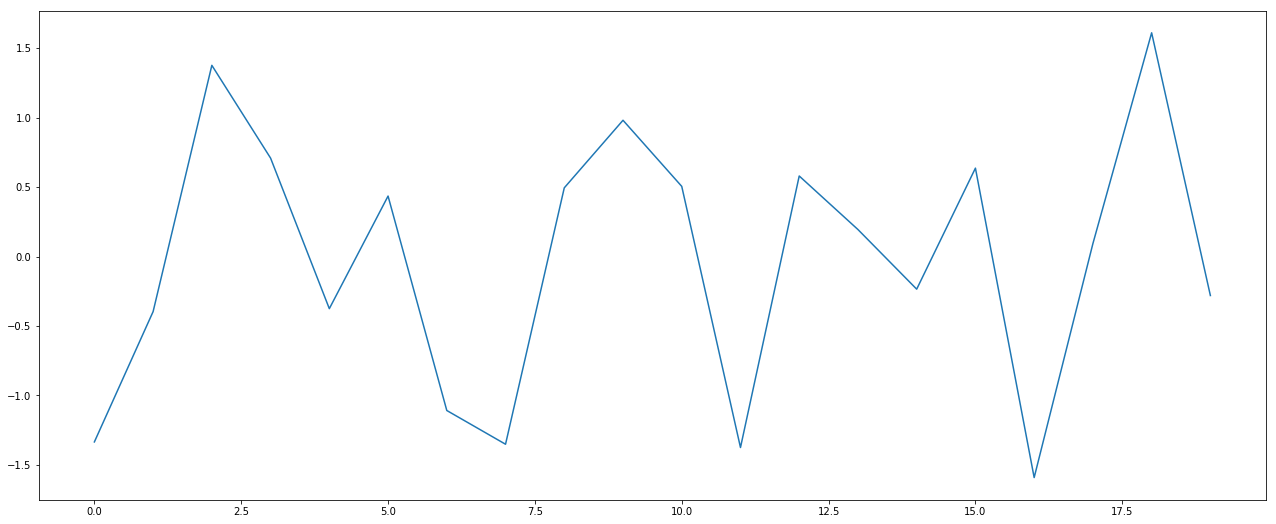

In [545]:
plt.plot(y_scalers['EAT'].inverse_transform(model.predict(X[100:120])))

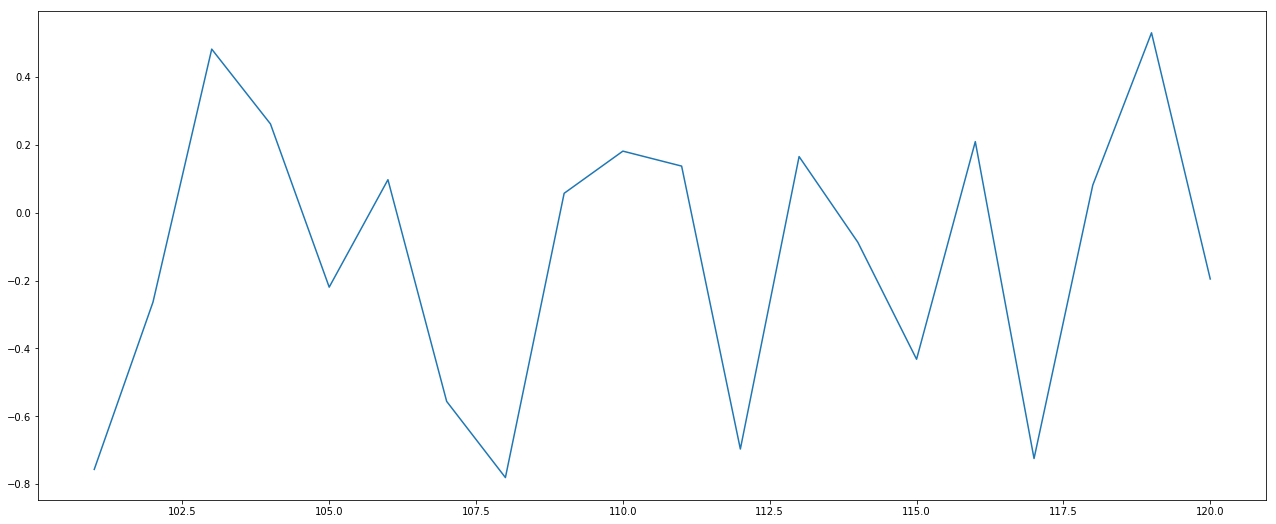

In [546]:
plt.plot(y[100:120])

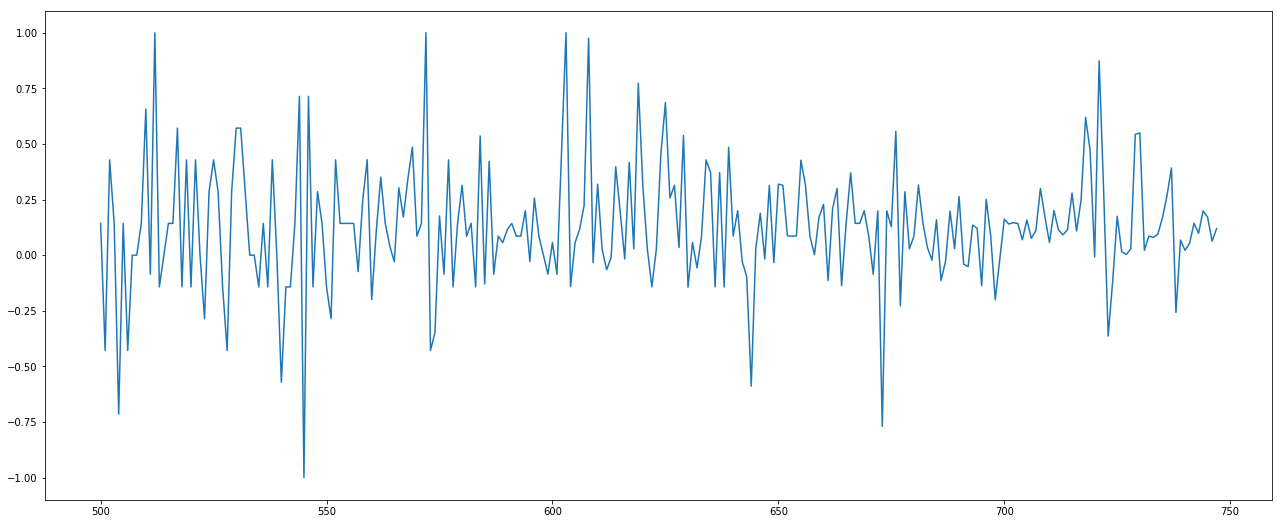

In [548]:
plt.plot(y[482:728]) # the range for TTNP

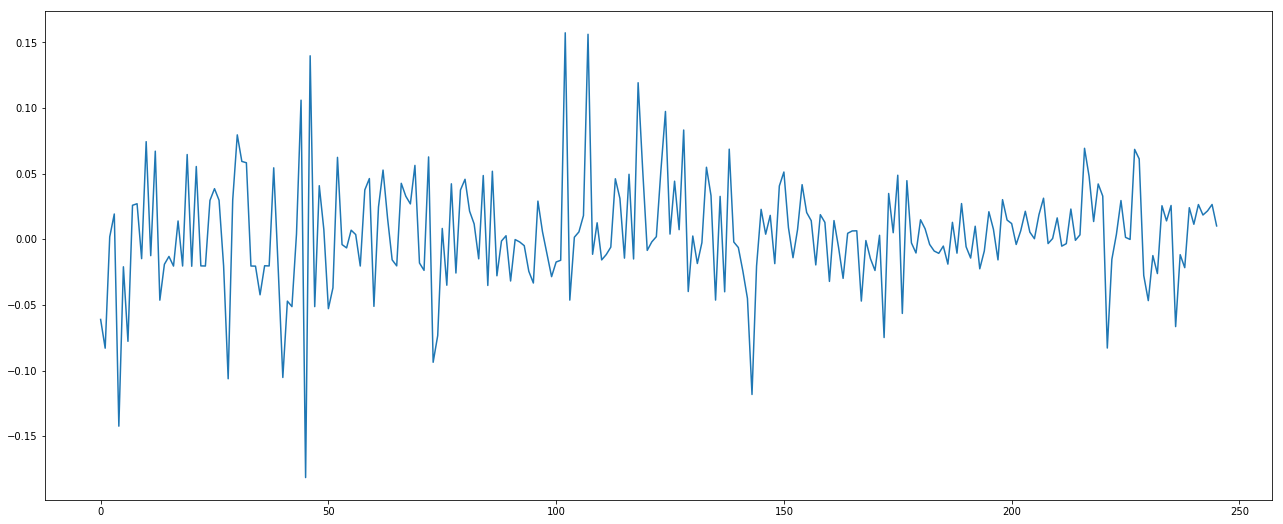

In [547]:
plt.plot(y_scalers['TTNP'].inverse_transform(model.predict(np.reshape(X[482:728], (-1, 1, num_df_cols)))))

In [549]:
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums

In [550]:
pad_stock('TWTR')

array([0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [551]:
model.save('./orig_model.h5')

## Pop off the model head and add a different one that we will finetune per stock

In [552]:
model.layers

In [553]:
model.pop()
model.pop()

In [554]:
# Freeze the 2 older dense layers
model.layers[0].trainable = False
model.layers[3].trainable = False

In [555]:
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

In [556]:
basket_dfs = {}
specific_models = {}
for stock in basket:
    basket_dfs[stock] = df[df['symbol'] == stock]
    specific_models[stock] = tf.keras.models.clone_model(model)
    specific_models[stock].set_weights(model.get_weights())

In [557]:
specific_models['EAT'].layers

In [560]:
for stock in basket:
    specific_models[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [576]:
Xes = {}
ys = {}
for stock in basket:
    repeated_dummies = pad_stock(stock).reshape(1,-1).repeat(len(basket_dfs[stock]),axis=0)
    Xes[stock] = np.append(basket_dfs[stock].drop(['tomo_gain', 'symbol'], axis=1).values, repeated_dummies, axis=1)
    Xes[stock] = np.reshape(Xes[stock], (-1, 1, num_df_cols))
    ys[stock] = basket_dfs[stock]['tomo_gain'].values.reshape(-1,1)

In [581]:
for stock in basket:
    specific_models[stock].fit(Xes[stock], ys[stock], batch_size=64, epochs=20, verbose=1)

Epoch 1/20
246/246 [==============================] - 0s 108us/step - loss: 0.0303 - mean_squared_error: 0.0303
Epoch 2/20
246/246 [==============================] - 0s 105us/step - loss: 0.0283 - mean_squared_error: 0.0283
Epoch 3/20
246/246 [==============================] - 0s 118us/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 4/20
246/246 [==============================] - 0s 126us/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 5/20
246/246 [==============================] - 0s 152us/step - loss: 0.0311 - mean_squared_error: 0.0311
Epoch 6/20
246/246 [==============================] - 0s 120us/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 7/20
246/246 [==============================] - 0s 142us/step - loss: 0.0280 - mean_squared_error: 0.0280
Epoch 8/20
246/246 [==============================] - 0s 139us/step - loss: 0.0308 - mean_squared_error: 0.0308
Epoch 9/20
246/246 [==============================] - 0s 127us/step - loss: 0.0268 - mean_squared_error:

246/246 [==============================] - 0s 116us/step - loss: 0.0200 - mean_squared_error: 0.0200
Epoch 14/20
246/246 [==============================] - 0s 132us/step - loss: 0.0199 - mean_squared_error: 0.0199
Epoch 15/20
246/246 [==============================] - 0s 133us/step - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 16/20
246/246 [==============================] - 0s 136us/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 17/20
246/246 [==============================] - 0s 117us/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 18/20
246/246 [==============================] - 0s 119us/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 19/20
246/246 [==============================] - 0s 122us/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 20/20
246/246 [==============================] - 0s 132us/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 1/20
245/245 [==============================] - 0s 122us/step - loss: 0.0139 - mean_squared_error: 0.0

244/244 [==============================] - 0s 129us/step - loss: 0.0216 - mean_squared_error: 0.0216
Epoch 6/20
244/244 [==============================] - 0s 120us/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 7/20
244/244 [==============================] - 0s 118us/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 8/20
244/244 [==============================] - 0s 136us/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 9/20
244/244 [==============================] - 0s 128us/step - loss: 0.0238 - mean_squared_error: 0.0238
Epoch 10/20
244/244 [==============================] - 0s 117us/step - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 11/20
244/244 [==============================] - 0s 147us/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 12/20
244/244 [==============================] - 0s 173us/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 13/20
244/244 [==============================] - 0s 155us/step - loss: 0.0186 - mean_squared_error: 0.0186

# Sanity checks

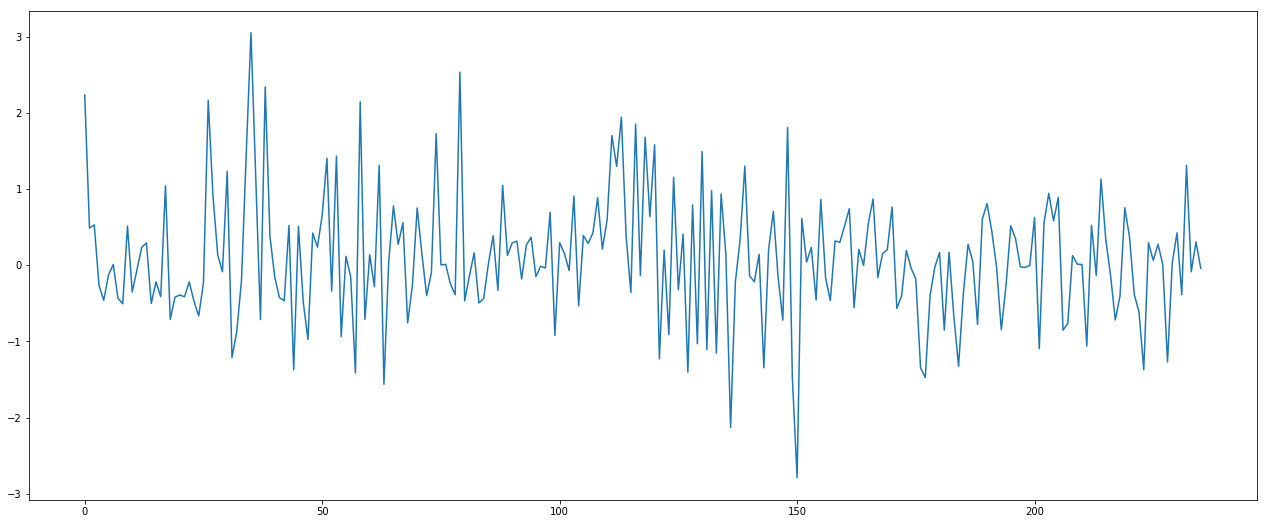

In [582]:
plt.plot(y_scalers['TWTR'].inverse_transform(specific_models['TWTR'].predict(Xes['TWTR'])))

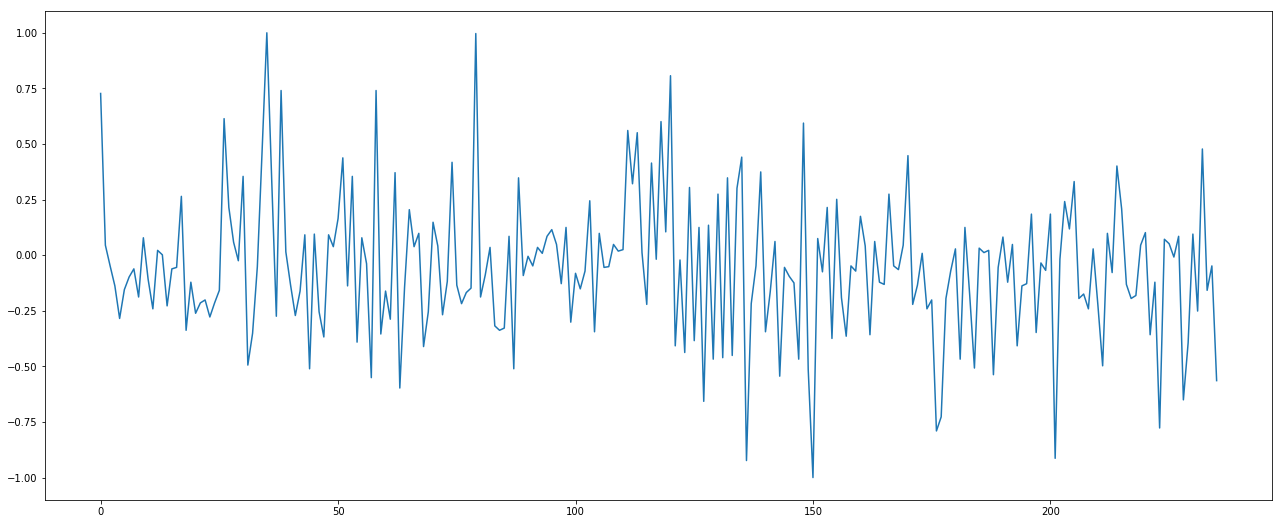

In [583]:
plt.plot(ys['TWTR'])

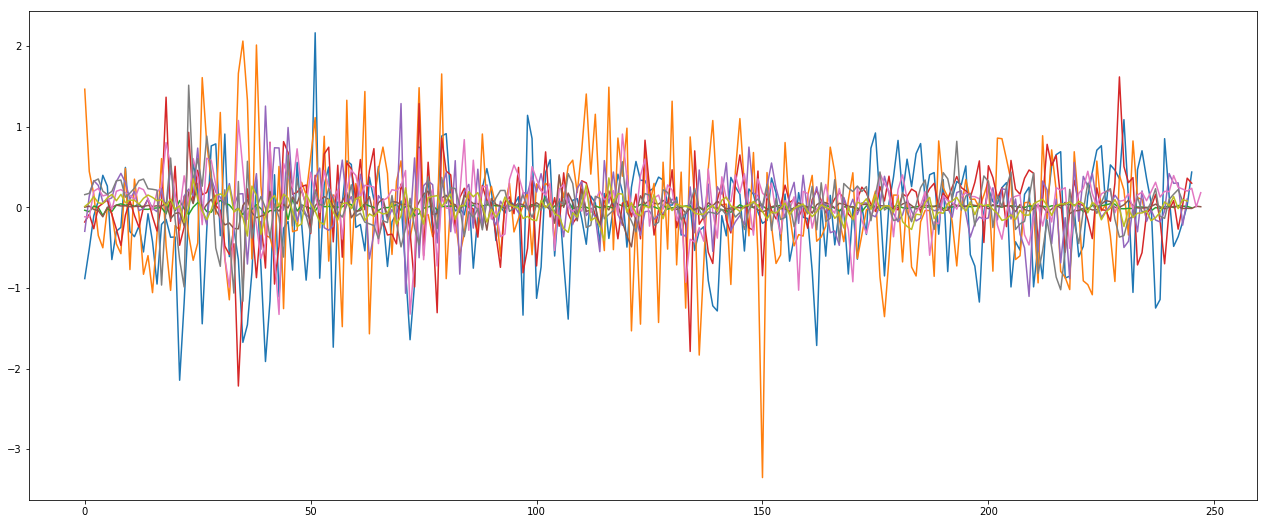

In [571]:
for stock in basket:
    plt.plot(y_scalers[stock].inverse_transform(specific_models[stock].predict(Xes[stock])))

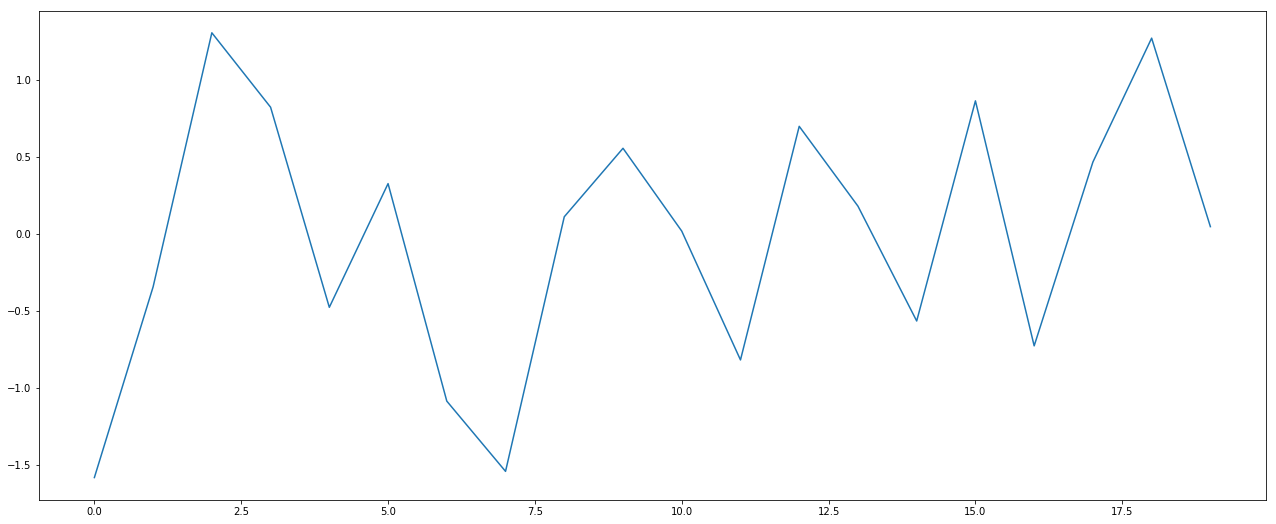

In [584]:
plt.plot(y_scalers['EAT'].inverse_transform(specific_models['EAT'].predict(Xes['EAT'][100:120])))

In [604]:
for stock in basket:
    today = df[df['symbol'] == stock].iloc[-1].drop(['tomo_gain', 'symbol'])
    today = np.append(today, pad_stock(stock))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(np.reshape(today, (-1, 1, num_df_cols)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asscalar(pred)))

Stock EAT, pred: 0.3860495686531067
Stock TWTR, pred: -0.04061765968799591
Stock TTNP, pred: -0.00742001086473465
Stock SBUX, pred: 0.2607242166996002
Stock BAC, pred: 0.3524315655231476
Stock SHLDQ, pred: -0.0009769650641828775
Stock STM, pred: 0.092579685151577
Stock ACB, pred: 0.08322916179895401
Stock GREK, pred: 0.11547408252954483
